## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [ ]:
# for google colab
from google.colab import drive
# mount your Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# for google colab
# copy all files from "HW1" directory in Google drive to current directory
!cp -r ./gdrive/MyDrive/HW3/* .

In [ ]:
import numpy as np

# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
    if len(sequence) == 0:
        return 0
    if len(np.unique(sequence)) == 1:
        return 0

    p = np.bincount(sequence) # pick up the number of ezch digit
    p = p / len(sequence) # pr
    return 1 - np.sum(np.square(p)) # formula

def entropy(sequence):
    if len(sequence) == 0:
        return 0 
    if len(np.unique(sequence)) == 1:
        return 0

    p = np.divide(np.bincount(sequence), len(sequence))
    p = p[p != 0] # delete 0 since log can't have 0
    return -np.sum(p * np.log2(p))

In [ ]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [ ]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [ ]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

train_df.head()

features = list(train_df.columns)[0:-1]
x_train, y_train = train_df[features], train_df['price_range']
x_train, y_train = x_train.values, y_train.values

x_test, y_test = val_df[features], val_df['price_range']
x_test, y_test = x_test.values, y_test.values

(1200, 21)
(300, 21)


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [ ]:
class Node():
    def __init__(self, X, y, criterion, cur_depth, max_depth, dataWeight=None):
        self.X, self.y = X, y
        self.left, self.right = None, None
        self.criterion = criterion
        self.cur_depth = cur_depth
        self.max_depth = max_depth
        self.isLeaf = False
        self.cls = None
        self.best_feature, self.best_threshold = None, None
        self.dataWeight = dataWeight


class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, num=0, isSOTA=False):
        self.criterion = criterion
        self.max_depth = max_depth
        self.root = None
        self.feature_count = np.zeros(num)
        self.max_features = None
        self.isSOTA = isSOTA

    def fit(self, x_data, y_data, dataWeight=None, max_features=None):
        # build decision tree
        X, y = x_data.copy(), y_data.copy()
        self.max_features = max_features
        self.root = Node(X, y, criterion=self.criterion, cur_depth=0, max_depth=self.max_depth, dataWeight=dataWeight)
        if dataWeight is None: # CART
            self.split(self.root)
        else:
            self.adaboost_split(self.root)

    def predict(self, x_data):
        # predict x_data in which class
        pred = []
        for x in x_data:
            cur_node = self.root
            while cur_node.isLeaf == False:
                #print(cur_node.best_threshold)
                if x[cur_node.best_feature] <= cur_node.best_threshold:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right 
            pred.append(cur_node.cls)

        return np.array(pred)
        
    def split(self, n):
        # print(n.cur_depth)
        # traverse decision tree
        # check whether reach terminal condition
        y_count = np.bincount(n.y, minlength=2)

        if n.cur_depth == self.max_depth or np.all(n.y == 0) or np.all(n.y == 1):
            n.isLeaf = True
            n.cls = np.argmax(y_count)
            return
    
        best_feature, best_threshold = self.find_threshold(n)
        n.best_feature, n.best_threshold = best_feature, best_threshold
        #print('best_threshold: ', best_threshold)

        # split data
        X_cls0 = n.X[(n.X[:, best_feature] <= best_threshold), :]
        X_cls1 = n.X[(n.X[:, best_feature] > best_threshold), :]
        y_cls0 = n.y[n.X[:, best_feature] <= best_threshold]
        y_cls1 = n.y[n.X[:, best_feature] > best_threshold]

        # continue to split
        n.left = Node(X_cls0, y_cls0, criterion=self.criterion, cur_depth=n.cur_depth + 1, max_depth=self.max_depth)
        n.right = Node(X_cls1, y_cls1, criterion=self.criterion, cur_depth=n.cur_depth + 1, max_depth=self.max_depth)
        self.split(n.left)
        self.split(n.right)

    def find_threshold(self, n):
        best_feature, best_threshold = None, None
        minImpurity = 1.0
        X, y = n.X.copy(), n.y.copy()

        featuresIndex = np.arange(len(X[0]))
        if self.max_features != None:
            featuresIndex = np.random.randint(len(X[0]), size=self.max_features)   

        for i in featuresIndex:
            #print('index: ', i)
            #print('n_val: ', X)
            #print('val: ', X[:, i])
            feature_val = np.unique(X[:, i])
            # categorical feature
            if len(feature_val) == 2 and (feature_val == np.array([0, 1])).all():
                #print('cate')
                y_cls0 = y[np.where(X[:, i] == 0)]
                y_cls1 = y[np.where(X[:, i] == 1)]
                
                impurity = self.get_weightImpurity(y_cls0, y_cls1) 
                #print('categorical impurity: ', impurity)
                if impurity < minImpurity:
                    minImpurity = impurity
                    best_feature = i
                    best_threshold = 0
            # numeric feature
            else:
                #print('numeric')
                # use method 2 to find best threshold
                # print(feature_val)
                for threshold in feature_val:
                    #print('current threshold: ', threshold)
                    y_cls0 = y[X[:, i] <= threshold]
                    y_cls1 = y[X[:, i] > threshold]

                    impurity = self.get_weightImpurity(y_cls0, y_cls1)
                    #print('numeric impurity: ', impurity)
                    if impurity < minImpurity:
                        minImpurity = impurity
                        best_feature = i
                        best_threshold = threshold

        #print('best_threshold: ', best_threshold)
        return best_feature, best_threshold                

    def get_weightImpurity(self, y_cls0, y_cls1):
        if self.criterion == 'gini':
            return (len(y_cls0) * gini(y_cls0) + len(y_cls1) * gini(y_cls1)) / (len(y_cls0) + len(y_cls1))
        else:
            return (len(y_cls0) * entropy(y_cls0) + len(y_cls1) * entropy(y_cls1)) / (len(y_cls0) + len(y_cls1))

    def adaboost_split(self, n):
        y_count = np.bincount(n.y, minlength=2)

        if n.cur_depth == self.max_depth or np.all(n.y == 0) or np.all(n.y == 1):
            n.isLeaf = True
            n.cls = np.argmax(y_count)
            return

        best_feature, best_threshold = self.find_adaboostThreshold(n)
        n.best_feature, n.best_threshold = best_feature, best_threshold
        #print('best_threshold: ', best_threshold)

        # split data
        X_cls0 = n.X[(n.X[:, best_feature] <= best_threshold), :]
        X_cls1 = n.X[(n.X[:, best_feature] > best_threshold), :]
        y_cls0 = n.y[n.X[:, best_feature] <= best_threshold]
        y_cls1 = n.y[n.X[:, best_feature] > best_threshold]
        w_cls0 = n.dataWeight[n.X[:, best_feature] <= best_threshold]
        w_cls1 = n.dataWeight[n.X[:, best_feature] > best_threshold]

        # continue to split
        n.left = Node(X_cls0, y_cls0, criterion=self.criterion, cur_depth=n.cur_depth + 1, max_depth=self.max_depth, dataWeight=w_cls0)
        n.right = Node(X_cls1, y_cls1, criterion=self.criterion, cur_depth=n.cur_depth + 1, max_depth=self.max_depth, dataWeight=w_cls1)
        self.split(n.left)
        self.split(n.right)

    def find_adaboostThreshold(self, n):
        best_feature, best_threshold = None, None
        minImpurity = 1.0
        X, y, dataWeight = n.X.copy(), n.y.copy(), n.dataWeight.copy()

        for i in range(len(X[0])):
            feature_val = np.unique(X[:, i])
            if len(feature_val) == 1:
                continue
            # categorical feature
            if len(feature_val) == 2 and (feature_val == np.array([0, 1])).all():
                y_cls0 = y[np.where(X[:, i] == 0)]
                y_cls1 = y[np.where(X[:, i] == 1)]
                w_cls0 = dataWeight[np.where(X[:, i] == 0)]
                w_cls1 = dataWeight[np.where(X[:, i] == 1)]

                impurity = self.get_adaboostWeight(y_cls0, y_cls1, w_cls0, w_cls1)
                if impurity < minImpurity:
                    minImpurity = impurity
                    best_feature = i
                    best_threshold = 0
            # numeric feature
            else:
                # use method 2 to find best threshold
                # print(feature_val)
                for threshold in feature_val:
                    #print('current threshold: ', threshold)
                    y_cls0 = y[X[:, i] <= threshold]
                    y_cls1 = y[X[:, i] > threshold]
                    w_cls0 = dataWeight[X[:, i] <= threshold]
                    w_cls1 = dataWeight[X[:, i] > threshold]

                    impurity = self.get_adaboostWeight(y_cls0, y_cls1, w_cls0, w_cls1)
                    if impurity < minImpurity:
                        minImpurity = impurity
                        best_feature = i
                        best_threshold = threshold

        #print('best_threshold: ', best_threshold)
        return best_feature, best_threshold
    
    def get_adaboostWeight(self, y_cls0, y_cls1, w_cls0, w_cls1):
        if self.criterion == 'gini':
            return (np.sum(w_cls0) * self.adaboost_gini(y_cls0, w_cls0) + np.sum(w_cls1) * self.adaboost_gini(y_cls1, w_cls1)) / (np.sum(w_cls0) + np.sum(w_cls1))
        else:
            return (np.sum(w_cls0) * self.adaboost_entropy(y_cls0, w_cls0) + np.sum(w_cls1) * self.adaboost_entropy(y_cls1, w_cls1)) / (np.sum(w_cls0) + np.sum(w_cls1))

    def adaboost_gini(self, y, w):
        # trun to sum up the value of data weight rather then number of occurence of the feature
        if len(y) == 0:
            return 0
        if len(np.unique(y)) == 1:
            return 0

        cls_count = list()
        cls_count.append(np.sum(w[np.where(y == 0)])) 
        cls_count.append(np.sum(w[np.where(y == 1)]))
        cls_count = np.array(cls_count)
        cls_count = cls_count / np.sum(w)

        return 1 - np.sum(np.square(cls_count))

    def adaboost_entropy(self, y, w):
        if len(y) == 0:
            return 0
        if len(np.unique(y)) == 1:
            return 0

        cls_count = list()
        cls_count.append(np.sum(w[np.where(y == 0)])) 
        cls_count.append(np.sum(w[np.where(y == 1)]))
        cls_count = np.array(cls_count)
        cls_count = cls_count / np.sum(w)

        return -np.sum(cls_count * np.log2(cls_count))

        
    def feature_importance(self, cur_node):
        if cur_node.isLeaf == True:
            return 
        
        self.feature_count[cur_node.best_feature] += 1
        self.feature_importance(cur_node.left)
        self.feature_importance(cur_node.right)
    
    def get_featureCount(self):
        return self.feature_count

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [ ]:
from sklearn.metrics import accuracy_score

clf_depth3 = DecisionTree(criterion='gini', max_depth=3, num=len(features))
clf_depth3.fit(x_train, y_train)
y_pred = clf_depth3.predict(x_test)
print('[Criterion]: gini & [Depth]: 3')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10, num=len(features))
clf_depth10.fit(x_train, y_train)
y_pred = clf_depth10.predict(x_test)
print('[Criterion]: gini & [Depth]: 10')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

[Criterion]: gini & [Depth]: 3
Accuarcy:  0.9166666666666666
[Criterion]: gini & [Depth]: 10
Accuarcy:  0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [ ]:
clf_gini = DecisionTree(criterion='gini', max_depth=3, num=len(features))
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_test)
print('[Criterion]: gini & [Depth]: 3')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3, num=len(features))
clf_entropy.fit(x_train, y_train)
y_pred = clf_entropy.predict(x_test)
print('[Criterion]: entropy & [Depth]: 3')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

[Criterion]: gini & [Depth]: 3
Accuarcy:  0.9166666666666666
[Criterion]: entropy & [Depth]: 3
Accuarcy:  0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

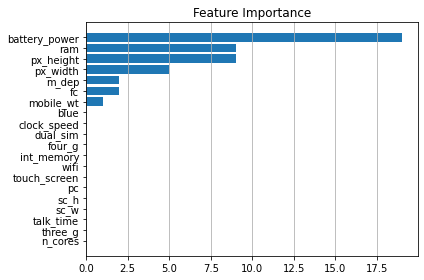

In [ ]:
import matplotlib.pyplot as plt

clf_depth10.feature_importance(clf_depth10.root)
features_count = clf_depth10.get_featureCount()
index = np.argsort(features_count)
sorted_feature = np.array(features)[index]
sorted_count = features_count[index]

plt.barh(sorted_feature, sorted_count)
plt.title('Feature Importance')
plt.gca().grid(axis='x', which='major')
plt.tight_layout()
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [ ]:
import math 

class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.weakClf = list()
        self.alpha = list()
        self.dataWeight = None

    def fit(self, x_data, y_data):
        X, y = x_data.copy(), y_data.copy()
        # initialize data weight (Dt)
        self.dataWeight = np.ones(len(y_data)) / len(y_data)
        # since h : x -> {-1, 1}, convert y == 0 to y == -1
        y[np.where(y == 0)] = -1

        for i in range(self.n_estimators):
            #print(i)
            #print(self.dataWeight)
            # construct a weak classifier and the max_depth=1
            clf = DecisionTree(criterion='entropy', max_depth=1)
            clf.fit(X, y_data, dataWeight=self.dataWeight)
            # addcoring to formula
            pred = clf.predict(X)
            pred[np.where(pred == 0)] = -1
            error = np.sum(self.dataWeight[np.where((pred * y) == -1)])  
            #error = self.dataWeight[y != pred].sum()
            # set weight classifier (alpha)
            #print('error: ', error)
            self.alpha.append(math.log((1 - error) / error) / 2)
            #print('alpha: ', self.alpha[-1])
            # update distribution (data weight)
            self.dataWeight = self.dataWeight * np.exp(- self.alpha[-1] * y * pred) 
            self.dataWeight = self.dataWeight / np.sum(self.dataWeight)
            self.weakClf.append(clf)

    def predict(self, x_data):
        # according to the formula: sign[H(x)=sigma(alpha*h(x))]
        pred = np.zeros(len(x_data))
        for alpha, clf in zip(self.alpha, self.weakClf):
            re = clf.predict(x_data)
            re[np.where(re == 0)] = -1
            pred += alpha * re
        
        pred = np.sign(pred)
        pred[np.where(pred == -1)] = 0
        return pred

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [ ]:
from sklearn.metrics import accuracy_score

clf_estimators10 = AdaBoost(n_estimators=10)
clf_estimators10.fit(x_train, y_train)
y_pred = clf_estimators10.predict(x_test)
print('[n_estimators]: 10')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

clf_estimators100 = AdaBoost(n_estimators=100)
clf_estimators100.fit(x_train, y_train)
y_pred = clf_estimators100.predict(x_test)
print('[n_estimators]: 100')
print('Accuarcy: ', accuracy_score(y_test, y_pred))


[n_estimators]: 10
Accuarcy:  0.94
[n_estimators]: 100
Accuarcy:  0.9766666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [ ]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None, isSOTA=False):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.bootstrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.weakClf = list()
        self.accuracy = list()
        self.isSOTA = isSOTA

    def fit(self, x_data, y_data):
        # Draw a bootstraped sataset (size is random if bootstrap. otherwise, size is the whole data)
        #if self.isSOTA:
          #np.random.seed(200000)

        X, y = x_data.copy(), y_data.copy()
        for i in range(self.n_estimators):
            dataIndex = np.arange(len(y)) # whole dataset
            if self.bootstrap:
                # random size subset
                dataIndex = np.random.randint(len(y), size=len(y))
            #print('dataIndex: ', dataIndex)
            #print('y: ', y[dataIndex])

            # grow a decision tree (weak classifier)
            clf = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
            clf.fit(X[dataIndex], y[dataIndex], max_features=self.max_features)
            y_pred = clf.predict(X)
            
            if self.isSOTA == False:
                self.weakClf.append(clf)
                continue

            if 0.975 < accuracy_score(y, y_pred):
                #print(accuracy_score(Y, y_pred))
                self.weakClf.append(clf)
                self.accuracy.append(accuracy_score(y, y_pred))
            
            #self.weakClf.append(clf)

    def predict(self, x_data):
        # Give x_data, feed it to all clf and use the majority vote
        pred = np.zeros((len(x_data)))
        y_pred = np.zeros((len(x_data)))
        for clf in self.weakClf:
            pred += clf.predict(x_data)

        y_pred[np.where(pred >= (len(self.weakClf) / 2))] = 1
        y_pred[np.where(pred < (len(self.weakClf) / 2))] = 0

        return y_pred

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [ ]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [ ]:
clf_10tree.fit(x_train, y_train)
y_pred = clf_10tree.predict(x_test)
print('[n_estimators]: 10')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

clf_100tree.fit(x_train, y_train)
y_pred = clf_100tree.predict(x_test)
print('[n_estimators]: 100')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

[n_estimators]: 10
Accuarcy:  0.92
[n_estimators]: 100
Accuarcy:  0.9433333333333334


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [ ]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [ ]:
clf_random_features.fit(x_train, y_train)
y_pred = clf_random_features.predict(x_test)
print('[max_feature]: partial')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

clf_all_features.fit(x_train, y_train)
y_pred = clf_all_features.predict(x_test)
print('[max_feature]: all')
print('Accuarcy: ', accuracy_score(y_test, y_pred))

[max_feature]: partial
Accuarcy:  0.91
[max_feature]: all
Accuarcy:  0.9566666666666667


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [ ]:
from sklearn.metrics import accuracy_score

train_df = pd.concat([train_df, val_df])

def train_your_model(data):
    ## Define your model and training
    features = list(data.columns)[0:-1]
    x_train, y_train = data[features], data['price_range']
    x_train, y_train = x_train.values, y_train.values

    clf = RandomForest(n_estimators=200, max_features=x_train.shape[1], isSOTA=True)
    clf.fit(x_train, y_train)

    return clf

In [ ]:
my_model = train_your_model(train_df)

KeyboardInterrupt: ignored

In [ ]:
y_pred = my_model.predict(x_test)

In [ ]:
np.save('y_pred.npy', y_pred)

In [ ]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [ ]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
